In [1]:
# Imports and setup
import sys
sys.path.append('..')

from src.data_prep import DataPreprocessor

In [2]:
# Initialize the data preprocessor
preprocessor = DataPreprocessor()

In [3]:
# Create datasets and dataloaders
train_loader, val_loader, df = preprocessor.create_datasets()

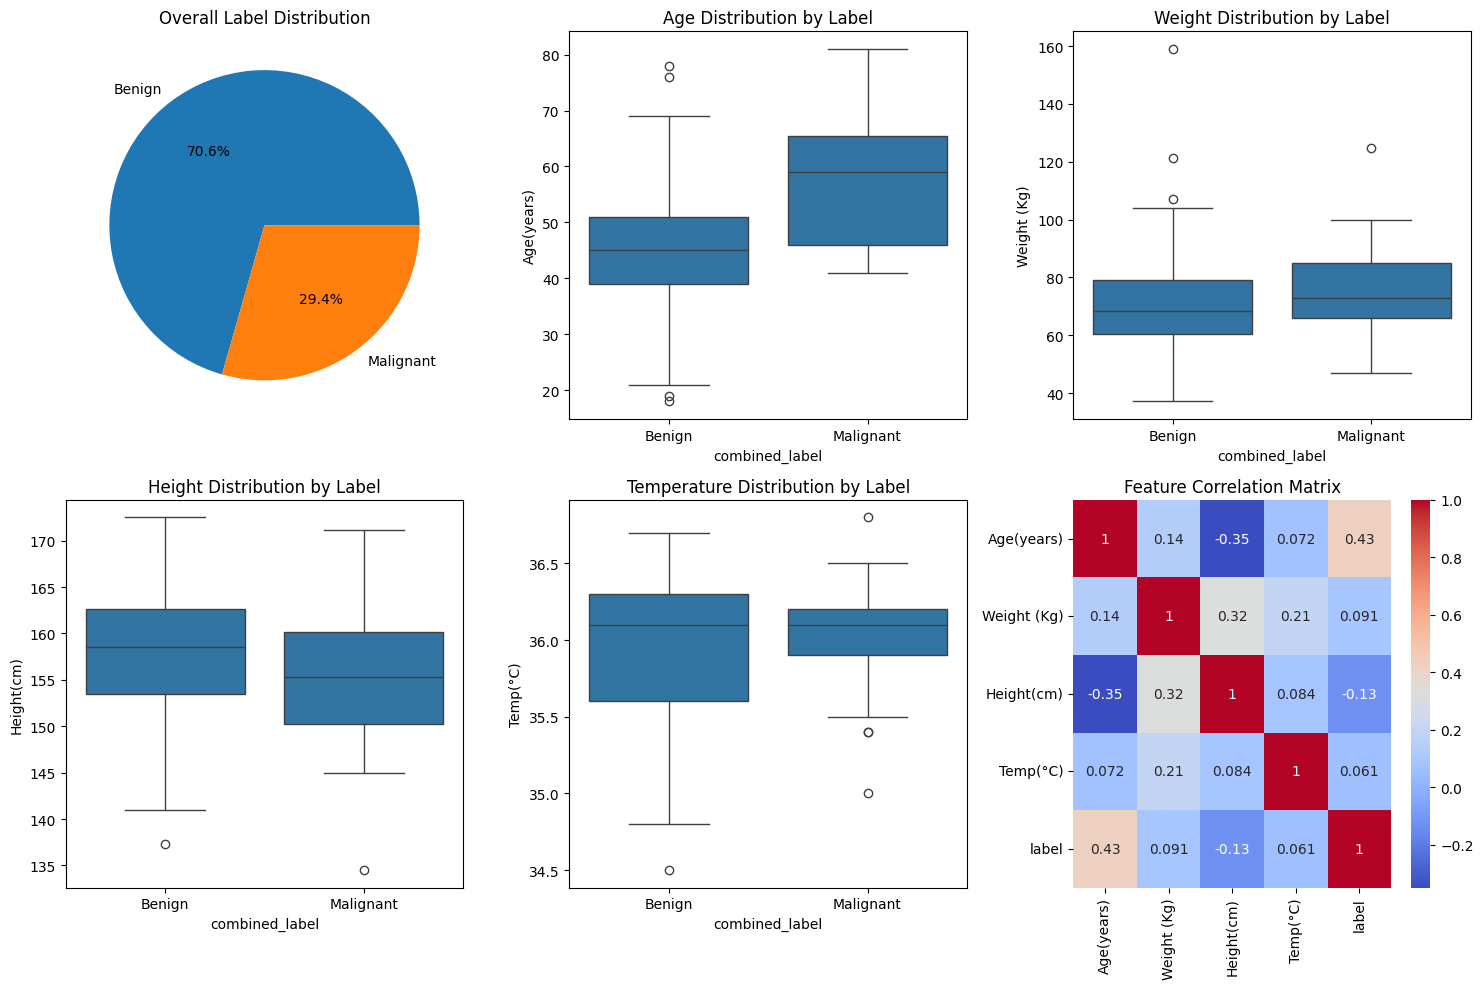

Dataset Statistics:
Total samples: 119
Label distribution:
combined_label
Benign       84
Malignant    35
Name: count, dtype: int64

Left breast status:
Left
N     52
PB    50
PM    17
Name: count, dtype: int64

Right breast status:
Right
N     65
PB    36
PM    18
Name: count, dtype: int64


In [4]:
# Visualize the data distribution
preprocessor.visualize_data_distribution(df, save_path="../outputs/plots")

In [5]:
# Print dataset information
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of classes: {len(df['combined_label'].unique())}")
print(f"Class distribution:\n{df['combined_label'].value_counts()}")

Number of training samples: 95
Number of validation samples: 24
Number of classes: 2
Class distribution:
combined_label
Benign       84
Malignant    35
Name: count, dtype: int64


In [6]:
# Some batch samples shape for confirmation
batch = next(iter(train_loader))
print(f"Sample batch image shape: {batch['image'].shape}")  # Should be (batch_size, 9, 224, 224)
print(f"Sample batch label shape: {batch['label'].shape}")

# Final class distribution
print(f"Training class distribution:\n{df['combined_label'].value_counts()}")

Sample batch image shape: torch.Size([8, 672, 3, 224])
Sample batch label shape: torch.Size([8])
Training class distribution:
combined_label
Benign       84
Malignant    35
Name: count, dtype: int64
